In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 250000000.0
lowcut = 10.0
highcut = 8000000.0

In [5]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

In [6]:
voltages = ['20220923_60V_laser_3725thres','20220923_61V_laser_3722thres','20220923_62V_laser_3722thres','20220923_63V_laser_3720thres','20220923_64V_laser_3718thres']

## Charge finger plot and average waveform
The charge finger plots have bad resolution for bias below 62V.
Average waveforms show the trigger position at sample 750 ($3\rm\mu s$)

ch0 20220923_60V_laser_3725thres
ch0 20220923_61V_laser_3722thres
ch0 20220923_62V_laser_3722thres
ch0 20220923_63V_laser_3720thres
ch0 20220923_64V_laser_3718thres
ch1 20220923_60V_laser_3725thres
ch1 20220923_61V_laser_3722thres
ch1 20220923_62V_laser_3722thres
ch1 20220923_63V_laser_3720thres
ch1 20220923_64V_laser_3718thres
ch2 20220923_60V_laser_3725thres
ch2 20220923_61V_laser_3722thres
ch2 20220923_62V_laser_3722thres
ch2 20220923_63V_laser_3720thres
ch2 20220923_64V_laser_3718thres
ch3 20220923_60V_laser_3725thres
ch3 20220923_61V_laser_3722thres
ch3 20220923_62V_laser_3722thres
ch3 20220923_63V_laser_3720thres
ch3 20220923_64V_laser_3718thres


Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

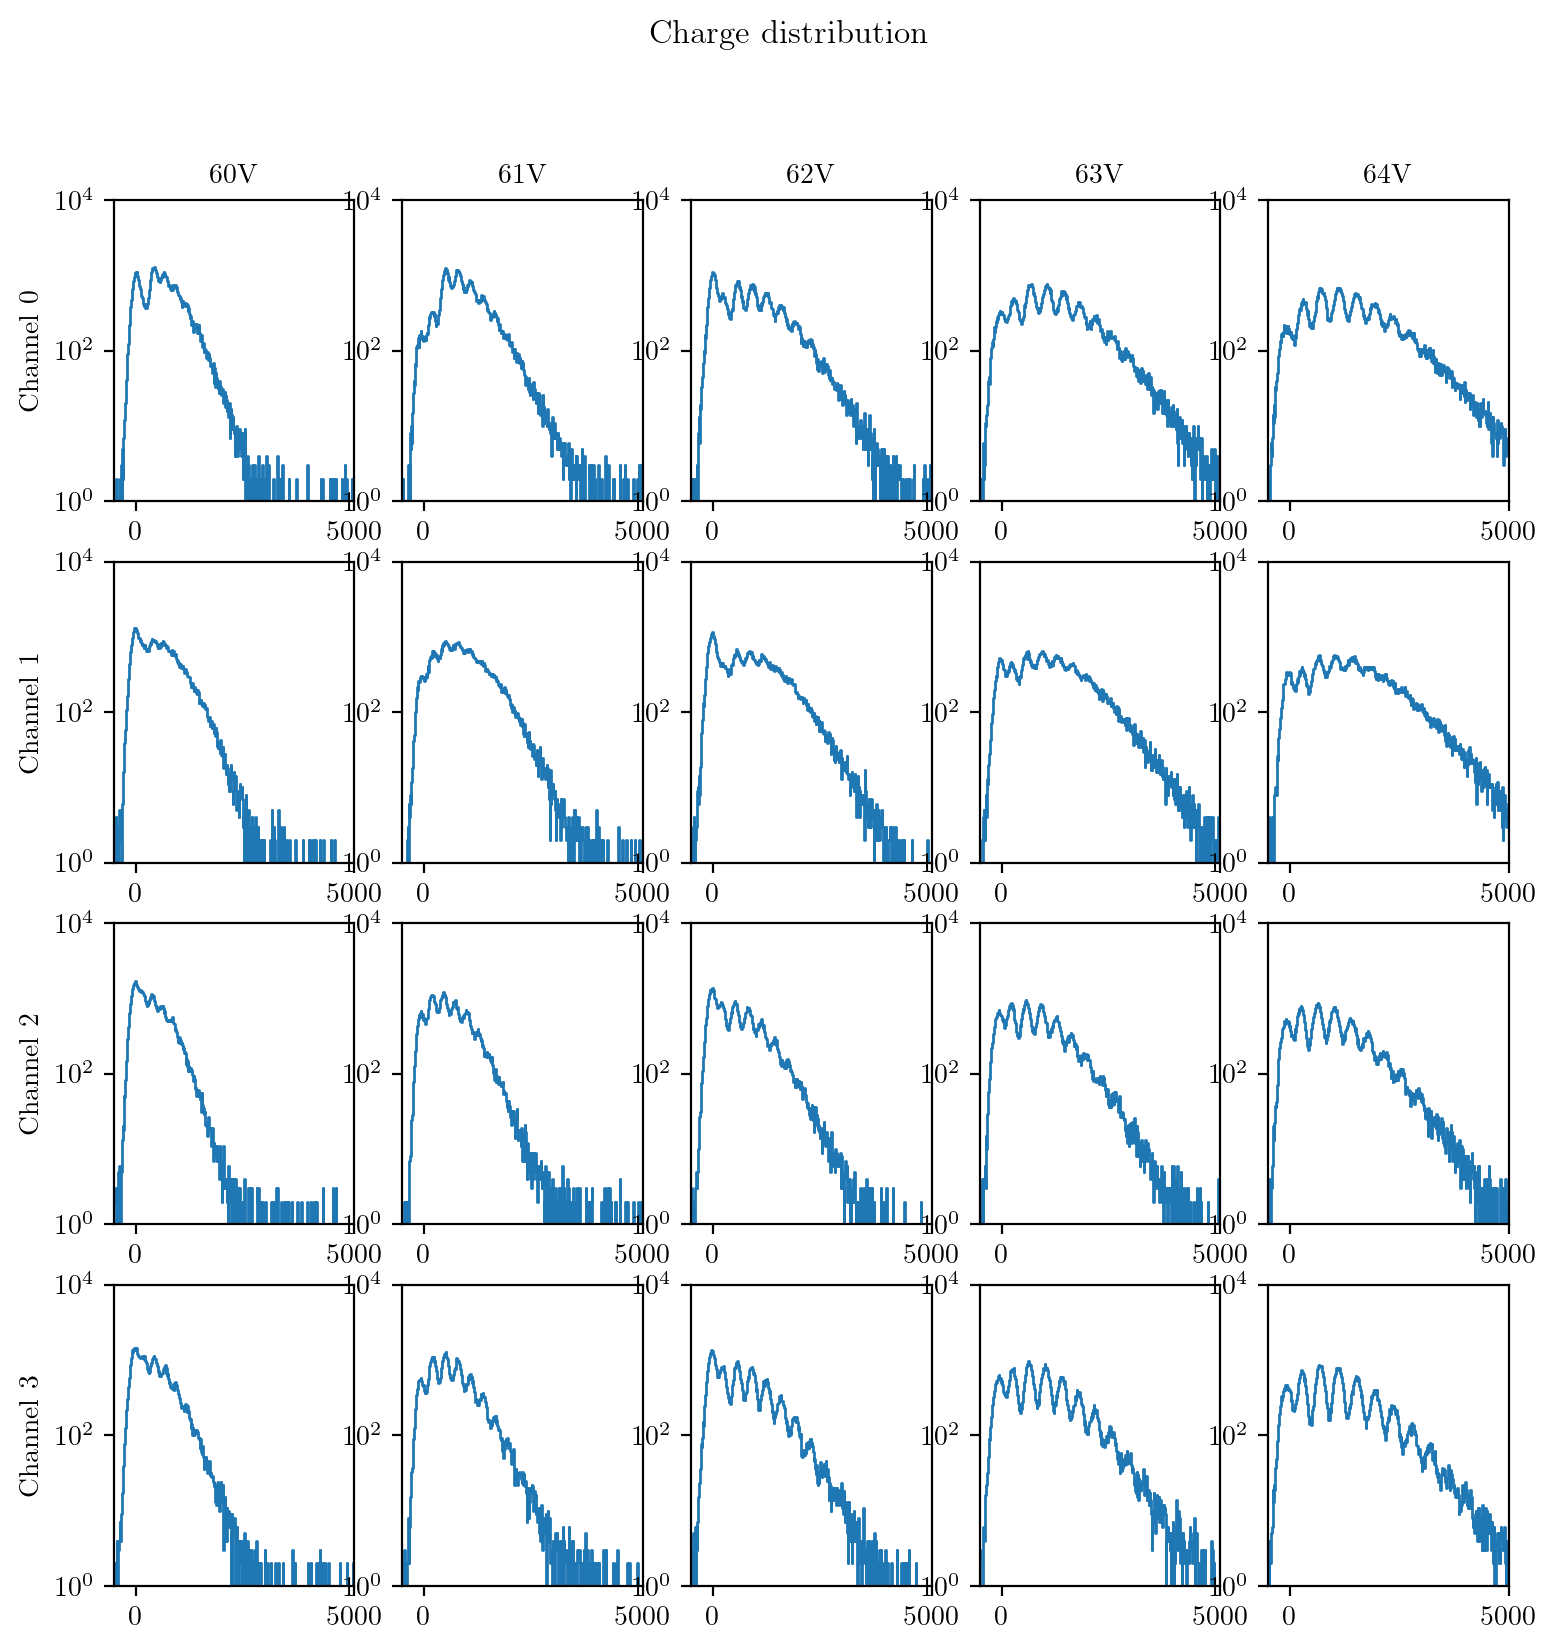

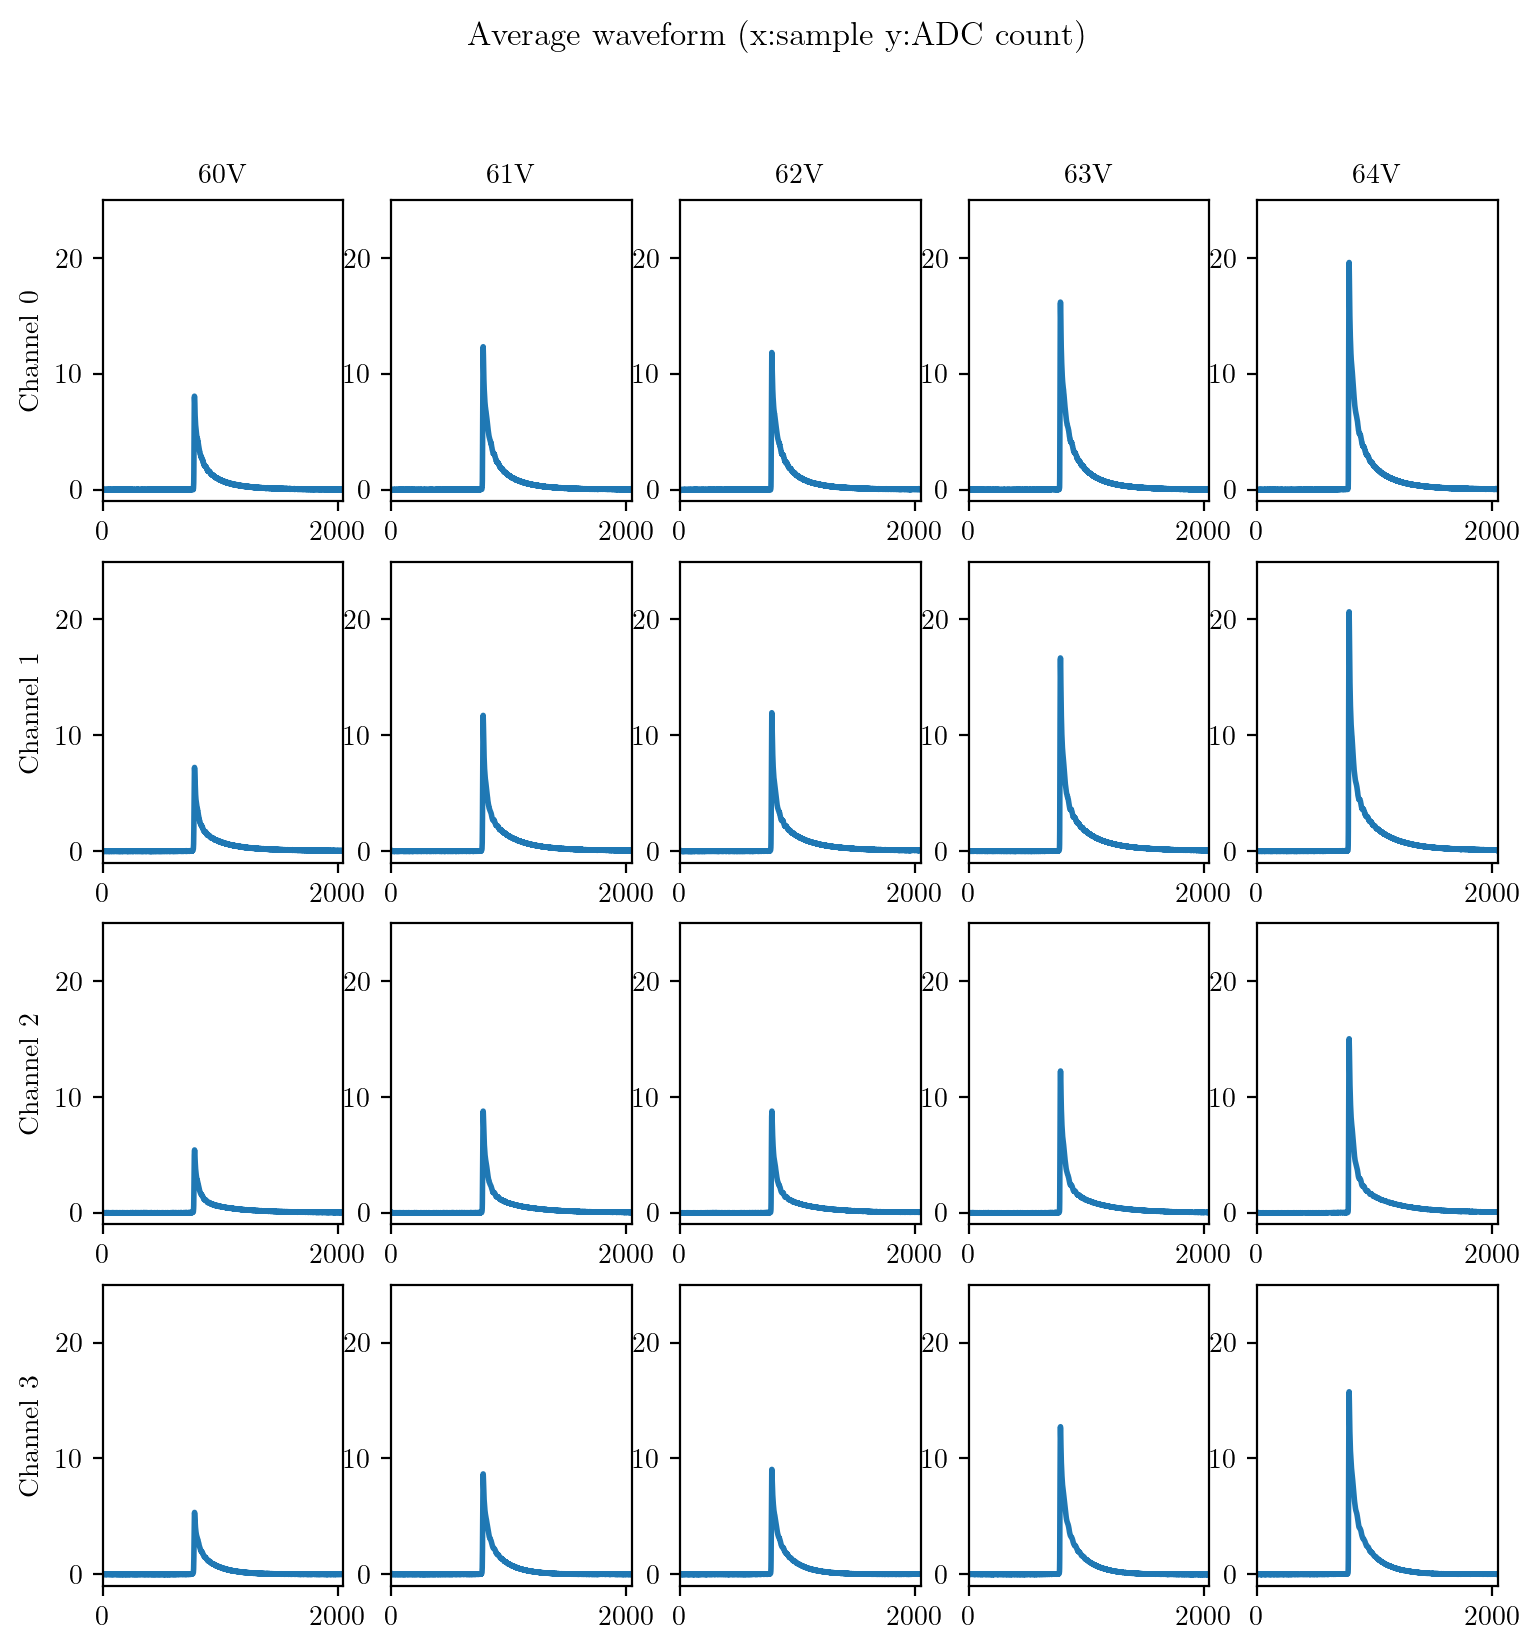

In [7]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [60, 61, 62, 63, 64]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs_sub_bsl = wfs
        integrals = []
        for i,wf in enumerate(wfs):
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            integrals.append(np.sum(wfs_sub_bsl[i][750:1200])) #integral between sample 750 and 1200
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 5000, 500))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 5000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in wfs_sub_bsl:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        plt.xlim(0,2048)
        plt.ylim(-1, 25)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

## Auto-regressive filter

In [7]:
def AR_filter(wf, tau):
    wf_filt = np.zeros(len(wf))
    for i,raw in enumerate(list(reversed(wf))):
        if i>0:
            wf_filt[i] = raw + wf_filt[i-1]*np.exp(-1/tau)
        else:
            wf_filt[i] = raw
    return list(reversed(wf_filt))

In [ ]:
h_ampfilt_ch_volt = np.zeros((4,5,1000))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,1000))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 100 #AR filter parameter (should = time constant of pulse shape)
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs = wfs[:50000] #use first 10000 waveforms
        wfs_sub_bsl = wfs
        wfs_filt = []
        amps_filt = []
        for i,wf in enumerate(wfs):
            if i%5000==0 and i/5000>0:
                print("{} waveforms".format(i))
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            wfs_filt.append(AR_filter(wfs_sub_bsl[i], tau))
            amps_filt.append(np.max(wfs_filt[i]))
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 1000, 1001))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

ch0 20220923_60V_laser_3725thres
5000 waveforms
10000 waveforms
15000 waveforms
20000 waveforms
25000 waveforms
30000 waveforms
35000 waveforms
40000 waveforms
45000 waveforms


In [ ]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [60, 61, 62, 63, 64]
tau = 100 #AR filter parameter (should = time constant of pulse shape)
gain = [[104, 216, 330, 446],#60V
        [110, 250, 380, 525],#61V
        [135, 290, 445, 610],#62V
        [170, 330, 510, 700],#63V
        [180, 370, 570, 790]]#64V
width = [[30, 40, 50, 60],#60V
         [30, 45, 50, 60],#61V
         [40, 50, 55, 60],#62V
         [50, 55, 60, 60],#63V
         [50, 55, 60, 60]]#64V
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id], prominence=15,distance=30,width=15)
        print("peaks:", peaks)
        #fit pe peaks with Gaussian
        pe_mean = []
        pe_width = 20
        for peak in peaks:
            xmin = peak-pe_width
            xmax = peak+pe_width
            binmin = int((xmin-h_ampfilt_bincent_ch_volt[ch][volt_id][0])/h_ampfilt_binwid_ch_volt[ch][volt_id])
            binpe = int((peak-h_ampfilt_bincent_ch_volt[ch][volt_id][0])/h_ampfilt_binwid_ch_volt[ch][volt_id])
            binmax = int((xmax-h_ampfilt_bincent_ch_volt[ch][volt_id][0])/h_ampfilt_binwid_ch_volt[ch][volt_id])
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][binmin:binmax], h_ampfilt_ch_volt[ch][volt_id][binmin:binmax], p0=[h_ampfilt_ch_volt[ch][volt_id][binpe], peak, pe_width], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][binmin:binmax], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][binmin:binmax], *popt), color=colors[1], lw=1, zorder=10)
            print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Vbd={:.3f}+/-{:.3f}V".format(popt[1],np.sqrt(pcov[1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.plot(xlin,ylin,'o')
    xlin.append(popt[1])
    sorted(xlin)
    plt.plot(xlin,line(np.array(xlin),*popt),'-')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

In [ ]:
for ch in [0]:
    for volt in voltages: 
        print("ch{} {}".format(ch, volt))
        
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        tt = np.arange(0,0.004*2048,0.004)

        amp = [] 
        integral = []

        for i,wvf in enumerate(traces):
            #i is event number
            #wvf is sample number
            if i % 10000 == 0:
                print(i)
            traces[i] = traces[i] - np.mean(traces[i][:500]) #subtract baseline (avg. of first 500 samples)
            traces[i] = butter_bandpass_filter(traces[i], lowcut, highcut, fs, order=3)
            amp.append(-np.min(traces[i]))
            integral.append(np.sum(traces[i][700:1500]))
        
        amp = np.array(amp)
        integral = np.array(integral)

        hamp,hamp_bins = np.histogram(amp, bins=np.arange(0,100,.1))
        peaks,pdict = find_peaks(hamp, prominence=100, width=10, distance=5)
        fig, ax = plt.subplots(figsize=(9,3), ncols=2,nrows=1)
        ww = 10 #fit range around PE peaks
        fit_p = []
        fit_c = []

        for x in peaks: 
            popt,pcov = curve_fit(gauss, hamp[:-1][x-ww:x+ww], hamp[x-ww:x+ww], p0=[hamp[x], hamp_bins[:-1][x], 2], maxfev=10000)
            ax[0].plot(hamp[:-1][x-ww:x+ww], gauss(hamp_bins[:-1][x-ww:x+ww], *popt), color=colors[1], lw=1, zorder=10)
            fit_p.append(popt)
            fit_c.append(pcov)

        ax[0].step(hamp_bins[:-1],hamp, where='post')
        ax[0].scatter(hamp_bins[peaks], hamp[peaks], color='r', s=3, zorder=10)
        ax[0].set_xlabel('ADC Unit')
        ax[0].set_ylabel('Counts')
        ax[0].set_yscale('log')
        ax[0].set_xlim(0,30)
        ax[0].set_ylim(1e0,1e4)

        popt,pcov = curve_fit(line, np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        xfit = np.linspace(0,20,100)

        gain = np.mean(np.diff(np.array(fit_p)[:,1]))
        print(gain)
        print(pp)

        ax[1].grid()
        ax[1].plot(xfit, line(xfit, *popt), color=colors[1], ls='--', label=r'$m={:.3f}\pm {:.3f}$/p.e.'.format(popt[0], perr[0]))
        ax[1].scatter(np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
        ax[1].set_xlabel('Number of p.e.')
        ax[1].set_ylabel('Amplitude [a.u.]')
        ax[1].set_xlim(0,10)
        ax[1].set_ylim(0,20)
        ax[1].legend(loc='lower right')

        plt.show()

In [ ]:
np.linspace(0,100,5)

In [ ]:
ch = 0
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_60V_laser_3725thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_61V_laser_3722thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_62V_laser_3722thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_63V_laser_3720thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_64V_laser_3718thres/wave{}.dat".format(ch)
fname = "/home/aj9512/jadwin-365/data/sipm/20220923_60V_scint_3710thres/wave{}.dat".format(ch)

In [ ]:
dt = np.dtype('<H')
file = open(fname, 'rb')
traces = np.fromfile(file, dtype=dt, count=-1)
file.close()

In [ ]:
traces = traces.reshape((-1,2048)).astype(float)
tt = np.arange(0,0.004*2048,0.004)

In [ ]:
y = butter_bandpass_filter(traces[1000], lowcut, highcut, fs, order=3)

plt.figure()
plt.plot(tt, traces[1000]-np.mean(traces[1000][:100]), label='original')
plt.plot(tt, y-np.mean(y[100:200]), label='filtered')
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(2,4)
plt.ylim(-50, 10)
plt.legend(loc='upper right')
plt.show()

In [ ]:
amp = [] 
integral = []

for i,wvf in enumerate(traces):
    if i % 10000 == 0:
        print(i)
    traces[i] = traces[i] - np.mean(traces[i][:100])
    traces[i] = butter_bandpass_filter(traces[i], lowcut, highcut, fs, order=3)
    amp.append(np.min(traces[i]))
    integral.append(np.sum(traces[i]))

In [ ]:
amp = np.array(amp)
integral = np.array(integral)

In [ ]:
plt.figure()

for i,wvf in enumerate(traces[::1000]):
    plt.plot(tt, wvf, lw=1, color='k', alpha=0.1)
# plt.plot(tt, np.mean(traces, axis=0), color='r')
# plt.vlines(x=0.4*np.max(tt), ymin=-100, ymax=20, linestyles='--', lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(2,8)
plt.ylim(-500, 10)
plt.show()

In [ ]:

h,hx = np.histogram(np.abs(amp), bins=np.arange(0,1000,.1))

pp,pdict = find_peaks(h, prominence=100, width=10, distance=5)

fig, ax = plt.subplots(figsize=(9,3), ncols=2,nrows=1)
ww = 10
fit_p = []
fit_c = []

# for x in pp: 
#     popt,pcov = curve_fit(gauss, hx[:-1][x-ww:x+ww], h[x-ww:x+ww], p0=[h[x], hx[:-1][x], 2], maxfev=10000)
#     ax[0].plot(hx[:-1][x-ww:x+ww], gauss(hx[:-1][x-ww:x+ww], *popt), color=colors[1], lw=1, zorder=10)
#     fit_p.append(popt)
#     fit_c.append(pcov)

ax[0].step(hx[:-1],h, where='post')
ax[0].scatter(hx[pp], h[pp], color='r', s=3, zorder=10)
ax[0].set_xlabel('Amplitude [mV]')
ax[0].set_ylabel('Counts')
ax[0].set_yscale('log')
ax[0].set_xlim(0,50)
ax[0].set_ylim(1e0,1e4)

# popt,pcov = curve_fit(line, np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
# perr = np.sqrt(np.diag(pcov))
# print(perr)
# xfit = np.linspace(0,20,100)

# gain = np.mean(np.diff(np.array(fit_p)[:,1]))
# print(gain)
# print(pp)

# ax[1].grid()
# ax[1].plot(xfit, line(xfit, *popt), color=colors[1], ls='--', label=r'$m={:.3f}\pm {:.3f}$/p.e.'.format(popt[0], perr[0]))
# ax[1].scatter(np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
# ax[1].set_xlabel('Number of p.e.')
# ax[1].set_ylabel('Amplitude [a.u.]')
# ax[1].set_xlim(0,10)
# ax[1].set_ylim(0,20)
# ax[1].legend(loc='lower right')

plt.show()

In [ ]:
plt.figure()
norm_all = []
for i,wvf in enumerate(traces[::100]):
    wvf_norm = -1*wvf/np.min(wvf)
    norm_all.append(wvf_norm)
    plt.plot(tt, wvf_norm, lw=1, color='k', alpha=0.01)

mean_norm = np.mean(norm_all, axis=0)
plt.plot(tt, mean_norm, color='r')

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(3,5)
plt.ylim(-2,2)
plt.show()

In [ ]:
def func(x,a,b,c,d,e):
    return a*np.exp(-x/b)+c*np.exp(-x/d)+e
def func2(x,a,b,c):
    return a*np.exp(-x/b)+c

def func3(x,base,V0,sigma,tau,mu,tau2):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))

def func4(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau))

popt2,pcov2 = curve_fit(func3, tt, -1*mean_norm, maxfev=10000, p0=[0, 1, 0.1, 0.03, 3.2, 1.], bounds=([-1,0,0,0,3,1],[1,2,2,1,3.5,2]))
xfit = np.linspace(0,10,100000)
print(popt2)

plt.figure()
plt.plot(tt, -1*mean_norm, color='k')
plt.plot(xfit, func3(xfit, *popt2), color='r', ls='-', label=r"$\tau_1={:.3f}\,\mu$s, $\tau_2={:.3f}\,\mu$s".format(popt2[3], popt2[-1]), lw=1)
plt.plot(xfit, func4(xfit,  *popt2[:-1]), color='b', ls='--', label="Singlet", lw=1)
plt.plot(xfit, func4(xfit,  popt2[0], popt2[1], popt2[2], popt2[-1],popt2[4]), color='g', ls='--', label="Triplet", lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(2,8)
plt.ylim(-1,1)
plt.legend(loc='upper right')
plt.show()